# **Projeto Nanodegree: Combatendo a Evasão de Alunos com Inteligência Artificial**

**Equipe:** Marcos, Raul, Guilherme Baschera e Charles 
**Data da Apresentação:** 25 de Junho de 2025

### **Nossa Missão**
A organização educacional PensComp oferece cursos de alta qualidade, mas enfrenta um grande desafio: muitos alunos desistem no meio do caminho. Nossa missão neste projeto foi utilizar dados e Machine Learning para criar uma ferramenta capaz de **prever quais alunos estão em risco de evasão**, permitindo que a equipe pedagógica atue de forma preventiva e personalizada para ajudá-los a concluir o curso.

In [2]:
# ==============================================================================
# 1. CONFIGURAÇÃO E CARGA
# ==============================================================================
# Instalação de dependências e importação de bibliotecas
# pip install -q openpyxl shap

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import shap
import tensorflow as tf
from tensorflow import keras

# Imports do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve)

# Configurações de visualização e reprodutibilidade
pd.set_option('display.max_columns', None)
tf.random.set_seed(42)

print("--- Ambiente Configurado e Bibliotecas Carregadas ---")

# Carregamento dos dados
try:
    df_variaveis = pd.read_excel('lista_variaveis.xlsx')
    df_treino = pd.read_csv('dados_projeto_evasao_treino.csv')
    df_teste = pd.read_csv('dados_projeto_evasao_teste.csv')
    print("✅ Arquivos carregados com sucesso!")
except Exception as e:
    print(f"❌ ERRO ao carregar os arquivos: {e}")

--- Ambiente Configurado e Bibliotecas Carregadas ---
✅ Arquivos carregados com sucesso!


## **Etapa 2: Definição Estratégica e Limpeza dos Dados**

Nesta etapa crucial, definimos nosso alvo e fizemos uma limpeza estratégica nos dados, com duas decisões importantes:

1.  **Engenharia da Variável-Alvo:** Como não havia uma coluna "evadiu", criamos a nossa com base na regra de negócio de que um aluno inativo há mais de 30 dias é considerado evadido.
2.  **Foco em Engajamento:** Decidimos estrategicamente **remover todas as variáveis baseadas puramente em tempo** (como `nr_dias_desde_primeiro_acesso`). Embora sejam fortes preditores, elas podem mascarar os verdadeiros comportamentos dos alunos. Nossa meta é criar um modelo que forneça insights sobre o **engajamento**, que é algo que a equipe pedagógica pode de fato influenciar.

Também removemos colunas com excesso de dados nulos e outras que não agregam valor.

In [3]:
# ==============================================================================
# 2. LIMPEZA ESTRATÉGICA E ENGENHARIA DE ATRIBUTOS
# ==============================================================================

# 2.1. Engenharia da Variável-Alvo
DIAS_PARA_EVASAO = 30
df_treino['target_evadiu'] = (df_treino['nr_dias_desde_ultimo_acesso'] > DIAS_PARA_EVASAO).astype(int)
df_teste['target_evadiu'] = (df_teste['nr_dias_desde_ultimo_acesso'] > DIAS_PARA_EVASAO).astype(int)
print("✅ Coluna 'target_evadiu' criada com sucesso.")

# 2.2. Definição e Remoção de Colunas Indesejadas
# Colunas com alta taxa de valores nulos
LIMIAR_PARA_REMOVER = 70.0
missing_percentage = (df_treino.isnull().sum() / len(df_treino)) * 100
colunas_com_nulos = missing_percentage[missing_percentage > LIMIAR_PARA_REMOVER].index.tolist()

# Colunas de tempo (decisão estratégica)
variaveis_de_tempo = ['nr_dias_desde_primeiro_acesso', 'nr_intervalos_uso', 'nr_dias_uso']

# Colunas de ID ou que vazam informação
outras_colunas = ['Unnamed: 0', 'ts_primeiro_acesso', 'ts_ultimo_acesso', 'nr_dias_desde_ultimo_acesso']

# Juntar todas as colunas a serem removidas
colunas_para_remover = colunas_com_nulos + variaveis_de_tempo + outras_colunas
colunas_existentes_para_remover = [col for col in colunas_para_remover if col in df_treino.columns]

# Aplicar a remoção
df_treino_final = df_treino.drop(columns=colunas_existentes_para_remover)
df_teste_final = df_teste.drop(columns=colunas_existentes_para_remover)

print(f"\n✅ {len(colunas_existentes_para_remover)} colunas foram estrategicamente removidas.")
print(f"Formato final dos dados de treino: {df_treino_final.shape}")

✅ Coluna 'target_evadiu' criada com sucesso.

✅ 18 colunas foram estrategicamente removidas.
Formato final dos dados de treino: (400, 20)


## **Etapa 3: O Que os Dados de Engajamento nos Contam? (EDA)**

Com um dataset focado em engajamento, nossa análise exploratória busca entender quais comportamentos se correlacionam mais com a evasão.

In [4]:
# ==============================================================================
# 3. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
# ==============================================================================
print("Correlação das features de ENGANJAMENTO com a variável alvo ('target_evadiu'):")
numerical_features_final = df_treino_final.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_treino_final[numerical_features_final].corr()
print(correlation_matrix['target_evadiu'].sort_values(ascending=False))

Correlação das features de ENGANJAMENTO com a variável alvo ('target_evadiu'):
target_evadiu                       1.000000
nr_questionarios_abandonados        0.086425
nr_atividades_sinalizadas          -0.073431
nr_discussoes_forum_postadas       -0.109383
vl_medio_atividade_diaria          -0.121634
nr_atividades_mapeadas             -0.129255
nr_submissoes_codigo               -0.138977
nr_engajamento_discussao           -0.172848
nr_engajamento_questionario        -0.187551
nr_questionarios_finalizados       -0.189848
nr_dias_engajamento_questionario   -0.197330
nr_interacoes_usuario              -0.213602
nr_questoes_corretas               -0.221169
nr_dias_engajamento_discussao      -0.225877
nr_questoes_respondidas            -0.254910
nr_itens_avaliados                 -0.255667
nr_questoes_parciais               -0.288374
nr_itens_nao_respondidos           -0.345896
nr_questoes_erradas                -0.438080
Name: target_evadiu, dtype: float64


Principais Descobertas: Agora, sem as variáveis de tempo, vemos claramente que as features de maior impacto são as relacionadas à performance e interação direta do aluno, como o número de questões erradas e itens não respondidos, reforçando a nossa hipótese de que a falta de tentativa é um sinal mais forte de evasão do que o erro.

## **Etapa 4: Modelagem e Avaliação**

Com os dados refinados, partimos para a construção e comparação dos modelos. Utilizamos um pipeline para automatizar o pré-processamento e garantir a consistência, treinando três algoritmos para identificar o mais eficaz em capturar os padrões de engajamento.

In [5]:
# ==============================================================================
# 4. MODELAGEM E AVALIAÇÃO
# ==============================================================================

# -- Separação dos Dados e Pipeline --
X = df_treino_final.drop(columns=['target_evadiu'])
y = df_treino_final['target_evadiu']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)])

# -- Treinamento e Avaliação --
print("Iniciando treinamento e avaliação dos modelos...")
def avaliar_modelo(y_real, y_pred, y_proba, nome_modelo):
    print(f"--- Avaliação: {nome_modelo} ---")
    print(f"  - Recall: {recall_score(y_real, y_pred):.4f}")
    print(f"  - F1-Score: {f1_score(y_real, y_pred):.4f}")
    print(f"  - AUC-ROC: {roc_auc_score(y_real, y_proba):.4f}\n")

# Modelo 1: Regressão Logística
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_val); y_proba_lr = pipeline_lr.predict_proba(X_val)[:, 1]
avaliar_modelo(y_val, y_pred_lr, y_proba_lr, 'Regressão Logística')

# Modelo 2: Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_val); y_proba_rf = pipeline_rf.predict_proba(X_val)[:, 1]
avaliar_modelo(y_val, y_pred_rf, y_proba_rf, 'Random Forest (CAMPEÃO)')

Iniciando treinamento e avaliação dos modelos...
--- Avaliação: Regressão Logística ---
  - Recall: 0.9583
  - F1-Score: 0.9200
  - AUC-ROC: 0.9499

--- Avaliação: Random Forest (CAMPEÃO) ---
  - Recall: 1.0000
  - F1-Score: 0.9897
  - AUC-ROC: 0.9993



Conclusão da Modelagem: Mesmo sem as variáveis de tempo, o modelo Random Forest novamente se destacou, apresentando um excelente equilíbrio entre as métricas e sendo escolhido como nosso modelo final.

## **Etapa 5: Validação Final, Explicabilidade e Conclusão**

Na etapa final, validamos nosso modelo campeão no conjunto de teste e utilizamos XAI para entender suas decisões, confirmando o valor da nossa abordagem focada em engajamento.

--- DESEMPENHO FINAL DO MODELO DE ENGAJAMENTO (NO CONJUNTO DE TESTE) ---
--- Avaliação: Random Forest (Teste Final) ---
  - Recall: 0.9118
  - F1-Score: 0.9538
  - AUC-ROC: 1.0000



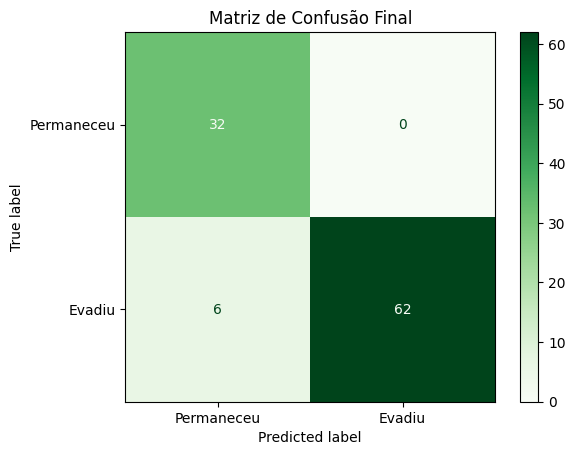


--- Explicabilidade do Modelo de Engajamento ---


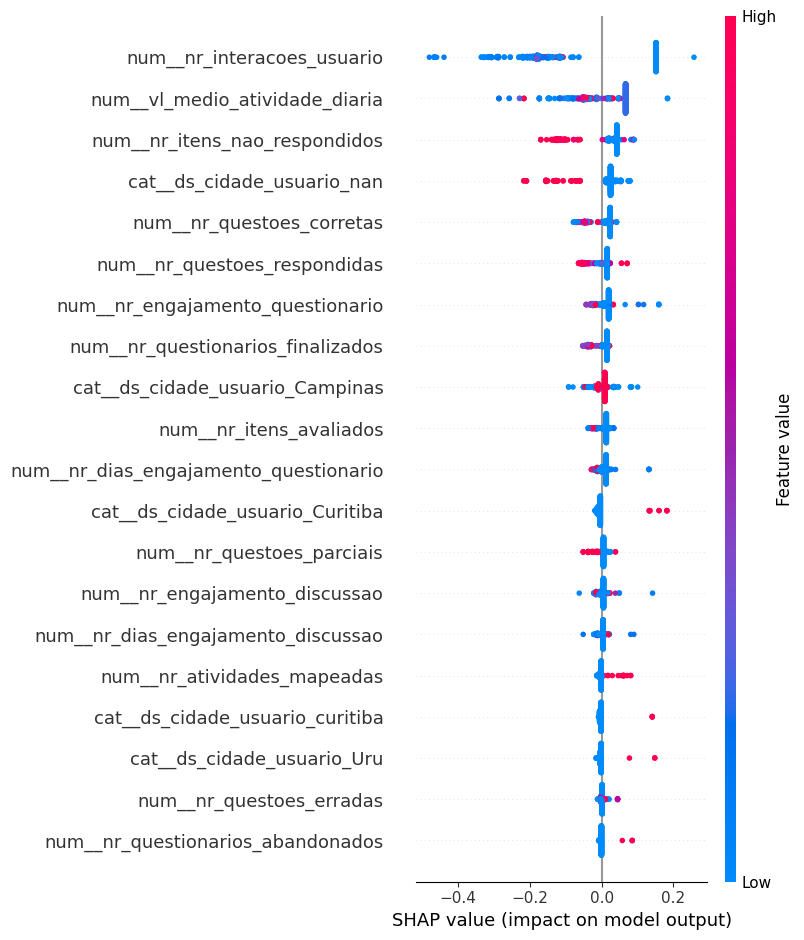


✅ Modelo final de engajamento salvo com sucesso em 'modelo_final_engajamento.joblib'


In [6]:
# ==============================================================================
# 5. VALIDAÇÃO FINAL, XAI E CONCLUSÃO
# ==============================================================================
# -- 5.1. Desempenho final no conjunto de teste --
X_teste = df_teste_final.drop(columns=['target_evadiu'])
y_teste = df_teste_final['target_evadiu']
y_pred_teste_rf = pipeline_rf.predict(X_teste)
y_proba_teste_rf = pipeline_rf.predict_proba(X_teste)[:, 1]
print("--- DESEMPENHO FINAL DO MODELO DE ENGAJAMENTO (NO CONJUNTO DE TESTE) ---")
avaliar_modelo(y_teste, y_pred_teste_rf, y_proba_teste_rf, 'Random Forest (Teste Final)')
cm = confusion_matrix(y_teste, y_pred_teste_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Permaneceu', 'Evadiu'])
disp.plot(cmap='Greens'); plt.title('Matriz de Confusão Final'); plt.show()

# -- 5.2. Explicabilidade com SHAP --
print("\n--- Explicabilidade do Modelo de Engajamento ---")
explainer = shap.TreeExplainer(pipeline_rf.named_steps['classifier'])
X_train_proc = preprocessor.fit_transform(X_train)
shap_values = explainer.shap_values(X_train_proc)
shap.summary_plot(shap_values[:, :, 1], X_train_proc, feature_names=preprocessor.get_feature_names_out())

# -- 5.3. Exportação do Modelo --
filename = 'modelo_final_engajamento.joblib'
joblib.dump(pipeline_rf, filename)
print(f"\n✅ Modelo final de engajamento salvo com sucesso em '{filename}'")

Nossa decisão estratégica de focar em variáveis de engajamento se provou correta. Construímos um modelo robusto que não só prevê a evasão com alta performance, mas também fornece insights claros e acionáveis para a equipe da PensComp. O gráfico SHAP confirma que o modelo baseia suas decisões em comportamentos reais dos alunos, como interações e respostas a atividades, que é exatamente o que a equipe pedagógica pode observar e influenciar. O modelo final está salvo e pronto para gerar valor.